## Ensure zfp compression 

In [1]:
# Install pyzfp package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pyzfp
import pyzfp

## Imports

In [2]:
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration, norm)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.self_adjoint import setup_w_over_q
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer
import copy

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# We define 32 bit floating point as the precision type 
dtype = np.float32

# Set logging to debug, captures statistics on the performance of operators
# configuration['log-level'] = 'DEBUG'
configuration['log-level'] = 'INFO'

configuration['language'] = 'openmp'

## Model

In [3]:
# Define dimensions for the interior of the model
nx,nz = 201,201
dx,dz = 10.0,10.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = (0., 0.)  # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define dimensions for the model padded with absorbing boundaries
npad = 10          # number of points in absorbing boundary region (all sides)
nxpad,nzpad = nx + 2 * npad, nz + 2 * npad
shape_pad   = np.array(shape) + 2 * npad
origin_pad  = tuple([o - s*npad for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

# Define the dimensions 
# Note if you do not specify dimensions, you get in order x,y,z
x = SpaceDimension(name='x', spacing=Constant(name='h_x', 
                   value=extent_pad[0]/(shape_pad[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', 
                   value=extent_pad[1]/(shape_pad[1]-1)))

# Initialize the Devito grid 
grid = Grid(extent=extent_pad, shape=shape_pad, origin=origin_pad, 
            dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)
print("")
print("shape_pad;       ", shape_pad)
print("origin_pad;      ", origin_pad)
print("extent_pad;      ", extent_pad)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

# NBVAL_IGNORE_OUTPUT

# Create the velocity and buoyancy fields as in the nonlinear notebook 
space_order = 8

# Wholespace velocity
m0 = Function(name='m0', grid=grid, space_order=space_order)
m0.data[:] = 1.5

# Perturbation to velocity: a square offset from the center of the model
dm = Function(name='dm', grid=grid, space_order=space_order)
size = 5
x0 = (shape_pad[0]-1)//2
z0 = (shape_pad[1]-1)//2
dm.data[:] = 0.0
dm.data[x0-size:x0+size, z0-size:z0+size] = 1.0

# Constant density
b = Function(name='b', grid=grid, space_order=space_order)
b.data[:,:] = 1.0 / 1.0

# Initialize the attenuation profile for Q=100 model
fpeak = 0.010
w = 2.0 * np.pi * fpeak
qmin = 0.1
qmax = 1000.0
wOverQ = Function(name='wOverQ', grid=grid, space_order=space_order)
setup_w_over_q(wOverQ, w, qmin, 100.0, npad)

def compute_critical_dt(v):
    """
    Determine the temporal sampling to satisfy CFL stability.
    This method replicates the functionality in the Model class.
    Note we add a safety factor, reducing dt by a factor 0.75 due to the
    w/Q attentuation term.
    Parameters
    ----------
    v : Function
        velocity
    """
    coeff = 0.38 if len(v.grid.shape) == 3 else 0.42
    dt = 0.75 * v.dtype(coeff * np.min(v.grid.spacing) / (np.max(v.data)))
    return v.dtype("%.5e" % dt)

shape;            (201, 201)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (2000.0, 2000.0)

shape_pad;        [221 221]
origin_pad;       (-100.0, -100.0)
extent_pad;       (2200.0, 2200.0)

grid.shape;       (221, 221)
grid.extent;      (2200.0, 2200.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


Operator `WOverQ_Operator` run in 0.10 s


## Acquisition geometry

In [4]:
t0 = 0.0     # Simulation time start
tn = 1200.0  # Simulation time end (1 second = 1000 msec)
dt = compute_critical_dt(m0)
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time min, max, dt, num; %10.6f %10.6f %10.6f %d" % (t0, tn, dt, int(tn//dt) + 1))
print("time_range; ", time_range)

# Source
src0 = RickerSource(name='src0', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src0.coordinates.data[0,0] = dx * ((nx-1)//2 - 15)
src0.coordinates.data[0,1] = dz * shape[1]//2

# Receivers 
rec0 = Receiver(name='rec0', grid=grid, npoint=nz, time_range=time_range)
rec0.coordinates.data[:,0] = dx * ((nx-1)//2 + 15)
rec0.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

rec1 = Receiver(name='rec1', grid=grid, npoint=nz, time_range=time_range)
rec1.coordinates.data[:,0] = dx * ((nx-1)//2 + 15)
rec1.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

Time min, max, dt, num;   0.000000 1200.000000   2.100000 572
time_range;  TimeAxis: start=0, stop=1201.2, step=2.1, num=573


## Plot model

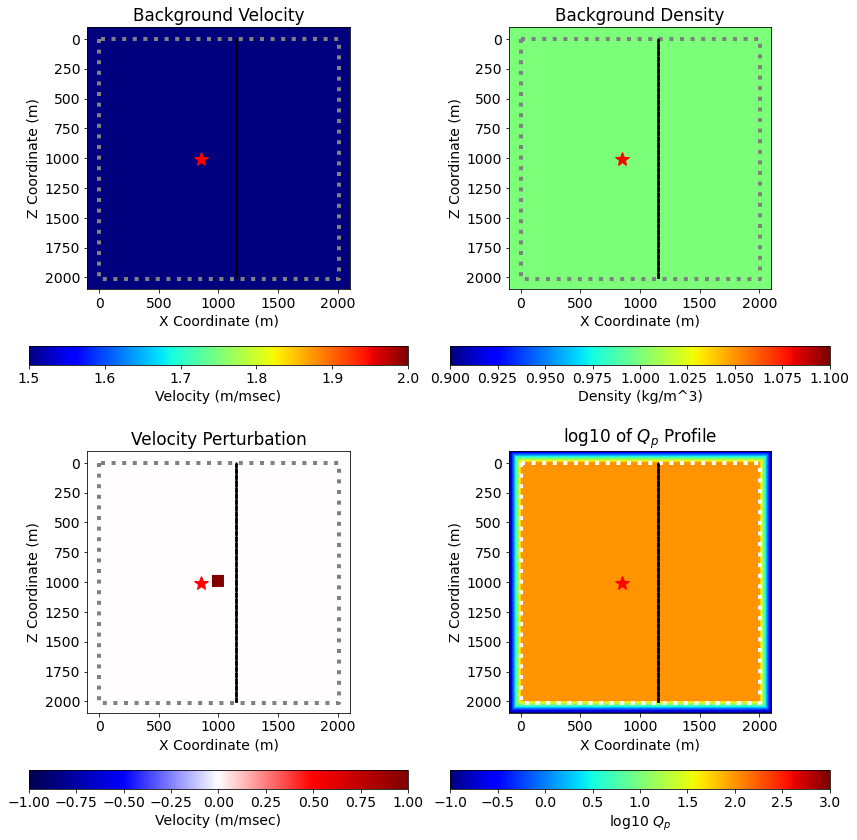

In [5]:
# NBVAL_INGNORE_OUTPUT

# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]

vmin, vmax = 1.5, 2.0
pmin, pmax = -1, +1
bmin, bmax = 0.9, 1.1

q = w / wOverQ.data[:]

x1 = 0.0
x2 = dx * nx
z1 = 0.0
z2 = dz * nz
abcX = [x1,x1,x2,x2,x1]
abcZ = [z1,z2,z2,z1,z1]

plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
plt.imshow(np.transpose(m0.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src0.coordinates.data[:, 0], src0.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec0.coordinates.data[:, 0], rec0.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background Velocity")

plt.subplot(2, 2, 2)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=bmin, vmax=bmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src0.coordinates.data[:, 0], src0.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec0.coordinates.data[:, 0], rec0.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Density (kg/m^3)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background Density")

plt.subplot(2, 2, 3)
plt.imshow(np.transpose(dm.data), cmap="seismic", 
           vmin=pmin, vmax=pmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src0.coordinates.data[:, 0], src0.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec0.coordinates.data[:, 0], rec0.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Velocity Perturbation")

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(np.log10(q.data)), cmap=cm.jet,
           vmin=np.log10(qmin), vmax=np.log10(qmax), extent=plt_extent)
plt.plot(abcX, abcZ, 'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src0.coordinates.data[:, 0], src0.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec0.coordinates.data[:, 0], rec0.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='log10 $Q_p$')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("log10 of $Q_p$ Profile")

plt.tight_layout()
None

## Define wavefields

In [6]:
# Define the TimeFunctions for nonlinear and Jacobian operations
nt = time_range.num
u0 = TimeFunction(name="u0", grid=grid, time_order=2, space_order=space_order, save=nt)
du = TimeFunction(name="duFwd", grid=grid, time_order=2, space_order=space_order, save=None)

# Get the dimensions for t, x, z 
t,x,z = u0.dimensions

## Nonlinear operator

In [7]:
# NBVAL_IGNORE_OUTPUT

# The nonlinear forward time update equation
eq_time_update_nl_fwd = (t.spacing**2 * m0**2 / b) * \
    ((b * u0.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) +
     (b * u0.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) + \
    (2 - t.spacing * wOverQ) * u0 + \
    (t.spacing * wOverQ - 1) * u0.backward

stencil_nl = Eq(u0.forward, eq_time_update_nl_fwd)

# Update the dimension spacing_map to include the time dimension
# Please refer to the first implementation notebook for more information
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Source injection and Receiver extraction
src_term0 = src0.inject(field=u0.forward, expr=src0 * t.spacing**2 * m0**2 / b)
rec_term0 = rec0.interpolate(expr=u0.forward)

# Instantiate and run the operator for the nonlinear forward
op_nl = Operator([stencil_nl] + src_term0 + rec_term0, subs=spacing_map)
u0.data[:] = 0
op_nl.apply()

rec0_copy = copy.copy(rec0)
u0_copy = copy.copy(u0)

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 2.1}


Operator `Kernel` run in 0.53 s


## Jacobian forward operator and linearization test

In [8]:
snrs = []
n1dict = {}
n2dict = {}
p1dict = {}
p2dict = {}

In [9]:
# NBVAL_IGNORE_OUTPUT

# The linearized forward time update equation
eq_time_update_ln_fwd = (t.spacing**2 * m0**2 / b) * \
    ((b * du.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) +
     (b * du.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2) + 
     2 * b * dm * m0**-3 * (wOverQ * u0.dt(x0=t-t.spacing/2) + u0.dt2)) +\
    (2 - t.spacing * wOverQ) * du + \
    (t.spacing * wOverQ - 1) * du.backward

stencil_ln_fwd = Eq(du.forward, eq_time_update_ln_fwd)

# Receiver container and receiver extraction for the linearized operator
rec_term1 = rec1.interpolate(expr=du.forward)

# compress and decompress the nonlinear wavefield
print("u0.data shape; ", u0.data.shape)
from pyzfp import compress, decompress

print(" ")
# have to jump through hoops to get zfp to work here ... not sure why
# something about a memoryview maybe
ucopy = np.ones((573,221,221), dtype=dtype)
ucopy[:] = u0_copy.data[:,:,:]
size = np.prod(u0_copy.data.shape)

print("u0_copy  min,max,rms; %+12.6f %+12.6f %+12.6f" % (np.min(u0_copy.data[:]), np.max(u0_copy.data[:]), 
       np.sqrt(np.linalg.norm(u0_copy.data[:]) / size)))
print("ucopy    min,max,rms; %+12.6f %+12.6f %+12.6f" % (np.min(ucopy.data[:]), np.max(ucopy.data[:]), 
       np.sqrt(np.linalg.norm(ucopy.data[:]) / size)))

tols = [10.0, 1.0, 0.1]
for tol in tols:
    c = compress(ucopy, tolerance=tol)
    u0.data[:] = decompress(c, u0.data.shape, u0.data.dtype, tolerance=tol)

    print("u0       min,max,rms; %+12.6f %+12.6f %+12.6f" % (np.min(u0.data[:]), np.max(u0.data[:]), 
           np.sqrt(np.linalg.norm(u0.data[:]) / size)))

    snr = 10 * np.log10(np.linalg.norm(u0_copy.data[:]) /  np.linalg.norm(u0_copy.data[:] - u0.data[:]))
    snr = "%05.2f" % snr
    snrs.append(snr)
    print("snr; ", snr)

    # Instantiate and run the operator for the linearized forward
    op_ln_fwd = Operator([stencil_ln_fwd] + rec_term1, subs=spacing_map)
    du.data[:] = 0
    op_ln_fwd.apply()

    # NBVAL_IGNORE_OUTPUT
    mm = Function(name='mm', grid=grid, space_order=space_order)

    # Solve F(m + h dm) for sequence of decreasing h
    dh = np.sqrt(2.0)
    h = 0.1
    nstep = 7
    scale = np.empty(nstep)
    norm1 = np.empty(nstep)
    norm2 = np.empty(nstep)
    for kstep in range(nstep):
        h = h / dh
        mm.data[:] = m0.data + h * dm.data
        u0.data[:] = 0
        rec0.data[:] = 0
        op_nl.apply(m0=mm)
        scale[kstep] = h
        norm1[kstep] = 0.5 * np.linalg.norm(rec0.data - rec0_copy.data)**2
        norm2[kstep] = 0.5 * np.linalg.norm(rec0.data - rec0_copy.data - h * rec1.data)**2

    p1 = np.polyfit(np.log10(scale), np.log10(norm1), 1)
    p2 = np.polyfit(np.log10(scale), np.log10(norm2), 1)

    n1dict.update( {snr : norm1} )
    n2dict.update( {snr : norm2} )
    p1dict.update( {snr : p1[0]} )
    p2dict.update( {snr : p2[0]} )

    print("\nlinearization F %s (so=%d) 1st (%.1f) = %.4f, 2nd (%.1f) = %.4f" %
          (shape, 8, dh**2, p1[0], dh**4, p2[0]))

u0.data shape;  (573, 221, 221)
 
u0_copy  min,max,rms;   -18.171183   +34.079922    +0.010181
ucopy    min,max,rms;   -18.171183   +34.079922    +0.010181
u0       min,max,rms;   -18.187500   +34.125000    +0.010181
snr;  09.84


Operator `Kernel` run in 0.17 s
Operator `Kernel` run in 0.08 s
Operator `Kernel` run in 0.10 s
Operator `Kernel` run in 0.11 s
Operator `Kernel` run in 0.13 s
Operator `Kernel` run in 0.11 s
Operator `Kernel` run in 0.11 s
Operator `Kernel` run in 0.11 s



linearization F (201, 201) (so=8) 1st (2.0) = 1.9520, 2nd (4.0) = 2.8730
u0       min,max,rms;   -18.219727   +34.127930    +0.010184
snr;  16.90


Operator `Kernel` run in 0.14 s
Operator `Kernel` run in 0.09 s
Operator `Kernel` run in 0.10 s
Operator `Kernel` run in 0.10 s
Operator `Kernel` run in 0.11 s
Operator `Kernel` run in 0.10 s
Operator `Kernel` run in 0.11 s
Operator `Kernel` run in 0.10 s



linearization F (201, 201) (so=8) 1st (2.0) = 1.9520, 2nd (4.0) = 3.8147
u0       min,max,rms;   -18.172089   +34.082031    +0.010181
snr;  27.28


Operator `Kernel` run in 0.25 s
Operator `Kernel` run in 0.19 s
Operator `Kernel` run in 0.19 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.08 s
Operator `Kernel` run in 0.09 s
Operator `Kernel` run in 0.08 s
Operator `Kernel` run in 0.08 s



linearization F (201, 201) (so=8) 1st (2.0) = 1.9520, 2nd (4.0) = 3.9421


## Plot results

['09.84', '16.90', '27.28']
snr,p1,p2;  09.84 1.9520392924598715 2.8729575903492464
snr,p1,p2;  16.90 1.9520392924598715 3.814652733730421
snr,p1,p2;  27.28 1.9520392924598715 3.9420632255312302


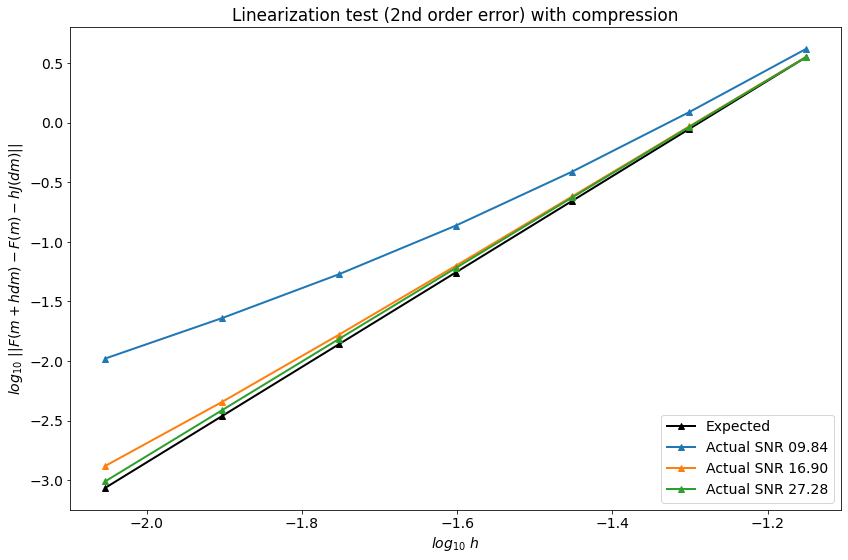

file;  image.snr.png


<Figure size 432x288 with 0 Axes>

In [10]:
# NBVAL_IGNORE_OUTPUT

print(snrs)

# Plot linearization tests
plt.figure(figsize=(12,8))

expected1 = np.empty(nstep)
expected2 = np.empty(nstep)

expected1[0] = norm1[0]
expected2[0] = norm2[0]

for kstep in range(1, nstep):
    expected1[kstep] = expected1[kstep - 1] / (dh**2)
    expected2[kstep] = expected2[kstep - 1] / (dh**4)

msize = 10

plt.plot(np.log10(scale), np.log10(expected2), label='Expected', color="black", linewidth=2, marker="^")
for snr in snrs:
    print("snr,p1,p2; ", snr, p1dict[snr], p2dict[snr])
    norms2 = n2dict[snr]
    plt.plot(np.log10(scale), np.log10(norms2), label='Actual SNR %s' % (snr), linewidth=2, marker="^")

plt.xlabel('$log_{10}\ h$')
plt.ylabel('$log_{10}\ \|| F(m+h dm) - F(m) - h J(dm)\||$')
plt.title('Linearization test (2nd order error) with compression')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

file = "image.snr.png"
print("file; ", file)
plt.savefig(file)